In [1]:
import os
import zipfile

# === 경로 설정 ===
zip_root = r"C:\AIhub\Training"  # .zip 파일들이 들어있는 최상위 폴더
target_root_01 = os.path.join(zip_root, "01.원천데이터")
target_root_02 = os.path.join(zip_root, "02.라벨링데이터")

# === 폴더가 없으면 생성 ===
os.makedirs(target_root_01, exist_ok=True)
os.makedirs(target_root_02, exist_ok=True)

# === 압축 해제 실행 ===
count = 0
for root, _, files in os.walk(zip_root):
    for file in files:
        if file.endswith(".zip"):
            zip_path = os.path.join(root, file)

            # 어떤 대상 폴더로 보낼지 구분 (TS → 원천데이터 / TL → 라벨링데이터)
            if file.startswith("TS_"):
                target_dir = target_root_01
            elif file.startswith("TL_"):
                target_dir = target_root_02
            else:
                print(f"❗ 무시: {file} (TS_ 또는 TL_로 시작 안 함)")
                continue

            try:
                with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                    for member in zip_ref.namelist():
                        if member.endswith(".json"):
                            # 하위 디렉토리 무시하고 파일만 추출
                            file_name = os.path.basename(member)
                            target_path = os.path.join(target_dir, file_name)
                            with zip_ref.open(member) as source_file, open(target_path, 'wb') as target_file:
                                target_file.write(source_file.read())
                print(f"📦 압축 해제 완료: {file}")
                count += 1
            except Exception as e:
                print(f"❌ 실패: {file} - {e}")

print(f"\n✅ 총 {count}개의 zip 압축 완료, 모든 파일이 원천/라벨링 폴더로 직접 들어갔습니다.")


📦 압축 해제 완료: TS_Part1_Clickbait_Auto_EC.zip
📦 압축 해제 완료: TS_Part1_Clickbait_Auto_ET.zip
📦 압축 해제 완료: TS_Part1_Clickbait_Auto_GB.zip
📦 압축 해제 완료: TS_Part1_Clickbait_Auto_IS.zip
📦 압축 해제 완료: TS_Part1_Clickbait_Auto_LC.zip
📦 압축 해제 완료: TS_Part1_Clickbait_Auto_PO.zip
📦 압축 해제 완료: TS_Part1_Clickbait_Auto_SO.zip
📦 압축 해제 완료: TS_Part1_Clickbait_Direct_EC.zip
📦 압축 해제 완료: TS_Part1_Clickbait_Direct_ET.zip
📦 압축 해제 완료: TS_Part1_Clickbait_Direct_GB.zip
📦 압축 해제 완료: TS_Part1_Clickbait_Direct_IS.zip
📦 압축 해제 완료: TS_Part1_Clickbait_Direct_LC.zip
📦 압축 해제 완료: TS_Part1_Clickbait_Direct_PO.zip
📦 압축 해제 완료: TS_Part1_Clickbait_Direct_SO.zip
📦 압축 해제 완료: TS_Part1_NonClickbait_Auto_EC.zip
📦 압축 해제 완료: TS_Part1_NonClickbait_Auto_ET.zip
📦 압축 해제 완료: TS_Part1_NonClickbait_Auto_GB.zip
📦 압축 해제 완료: TS_Part1_NonClickbait_Auto_IS.zip
📦 압축 해제 완료: TS_Part1_NonClickbait_Auto_LC.zip
📦 압축 해제 완료: TS_Part1_NonClickbait_Auto_PO.zip
📦 압축 해제 완료: TS_Part1_NonClickbait_Auto_SO.zip
📦 압축 해제 완료: TS_Part2_Clickbait_Auto_EC.zip
📦 압축 해제 완료: TS_Part

In [3]:
import os
import json
import pandas as pd
import time

# === 경로 설정 ===
source_root = r"C:\AIhub\Training\01.원천데이터"
label_root  = r"C:\AIhub\Training\02.라벨링데이터"
output_csv  = r"C:\AIhub\train_data.csv"

data = []
matched = 0
skipped = 0
error_files = []

# === 1. 라벨 파일 딕셔너리 생성 (_L.json → 원천 키) ===
label_map = {
    file.replace("_L.json", "").strip().lower(): os.path.join(label_root, file)
    for file in os.listdir(label_root)
    if file.endswith("_L.json")
}

# === 2. 전체 원천 파일 수집 ===
source_files = [f for f in os.listdir(source_root) if f.endswith(".json")]
total = len(source_files)

print(f"🔍 원천 파일 총 {total}개 병합 시작...")

# === 3. 병합 루프 ===
for i, file in enumerate(source_files, 1):
    file_key = file.replace(".json", "").strip().lower()
    source_path = os.path.join(source_root, file)
    label_path = label_map.get(file_key)

    if not label_path or not os.path.exists(label_path):
        skipped += 1
        if i % 5000 == 0:
            print(f"[{i}/{total}] ❗ 누락 누적: {skipped}")
        continue

    try:
        t1 = time.time()

        with open(source_path, "r", encoding="utf-8") as f_src:
            source = json.load(f_src)
        with open(label_path, "r", encoding="utf-8") as f_lbl:
            label = json.load(f_lbl)

        t2 = time.time()
        if t2 - t1 > 1.0:
            print(f"⏱ 느림: {file} - {round(t2 - t1, 2)}초")

        title = source.get("sourceDataInfo", {}).get("newsTitle", "")
        content = source.get("sourceDataInfo", {}).get("newsContent", "")
        label_value = label.get("labeledDataInfo", {}).get("clickbaitClass", None)

        if label_value in [0, 1]:
            data.append({
                "text": f"{title} {content}".strip(),
                "label": label_value
            })
            matched += 1
        else:
            skipped += 1

    except Exception as e:
        error_files.append((file, str(e)))
        skipped += 1

    if i % 10000 == 0:
        print(f"[{i}/{total}] 진행 중... ✅ {matched} 성공 / ❌ {skipped} 실패")

# === 4. 저장 ===
df = pd.DataFrame(data)
df.to_csv(output_csv, index=False, encoding="utf-8-sig")

print(f"\n✅ 전체 병합 완료: {matched}건 성공, {skipped}건 실패/누락")
print(f"📄 저장 위치: {output_csv}")

if error_files:
    print(f"⚠️ 예외 발생 파일 예시: {error_files[:3]}")


🔍 원천 파일 총 586741개 병합 시작...
[10000/586741] 진행 중... ✅ 10000 성공 / ❌ 0 실패
[20000/586741] 진행 중... ✅ 20000 성공 / ❌ 0 실패
[30000/586741] 진행 중... ✅ 30000 성공 / ❌ 0 실패
[40000/586741] 진행 중... ✅ 40000 성공 / ❌ 0 실패
[50000/586741] 진행 중... ✅ 50000 성공 / ❌ 0 실패
[60000/586741] 진행 중... ✅ 60000 성공 / ❌ 0 실패
[70000/586741] 진행 중... ✅ 70000 성공 / ❌ 0 실패
[80000/586741] 진행 중... ✅ 80000 성공 / ❌ 0 실패
[90000/586741] 진행 중... ✅ 90000 성공 / ❌ 0 실패
[100000/586741] 진행 중... ✅ 100000 성공 / ❌ 0 실패
[110000/586741] 진행 중... ✅ 110000 성공 / ❌ 0 실패
[120000/586741] 진행 중... ✅ 120000 성공 / ❌ 0 실패
[130000/586741] 진행 중... ✅ 130000 성공 / ❌ 0 실패
[140000/586741] 진행 중... ✅ 140000 성공 / ❌ 0 실패
[150000/586741] 진행 중... ✅ 150000 성공 / ❌ 0 실패
⏱ 느림: ET_M13_728820.json - 2.67초
[160000/586741] 진행 중... ✅ 160000 성공 / ❌ 0 실패
[170000/586741] 진행 중... ✅ 170000 성공 / ❌ 0 실패
[180000/586741] 진행 중... ✅ 180000 성공 / ❌ 0 실패
[190000/586741] 진행 중... ✅ 190000 성공 / ❌ 0 실패
[200000/586741] 진행 중... ✅ 200000 성공 / ❌ 0 실패
⏱ 느림: GB_M11_181902.json - 1.32초
[210000/586741] 진행 중... ✅

✅ pandas import 시작
✅ pandas import 완료
📥 CSV 파일 로드 중...
✅ CSV 로딩 완료
📥 sklearn, matplotlib 등 필요한 라이브러리 import 중...
✅ 라이브러리 import 완료
🔧 데이터 프레임 컬럼 소문자 및 공백 제거 중...
✅ 컬럼명 처리 완료: ['text', 'label']
🔎 텍스트 및 라벨 열 자동 감지 중...
✅ 텍스트 열: 'text', 라벨 열: 'label' 감지 완료
📉 데이터 일부 샘플링 중 (최대 2000개)...
✅ 샘플링 완료: 2000개
🔀 학습/검증 데이터 분할 중...
✅ 데이터 분할 완료: 학습 1600개, 검증 400개
🔤 TF-IDF 벡터화 중...
✅ TF-IDF 벡터화 완료
⚙️ SVM 모델 학습 중 (선형 커널)...
✅ SVM 모델 학습 완료
🔍 예측 및 평가 중...
✅ 예측 완료
📊 TF-IDF + SVM 분류 결과
              precision    recall  f1-score   support

           0       0.47      0.61      0.53       186
           1       0.54      0.40      0.46       214

    accuracy                           0.50       400
   macro avg       0.50      0.50      0.50       400
weighted avg       0.51      0.50      0.49       400

📈 혼동 행렬 시각화 중...


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\utils.py:61: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\utils.py:61: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\utils.py:61: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\utils.py:61: UserWarning: Glyph 48624 (\N{HANGUL SYLLABLE BY

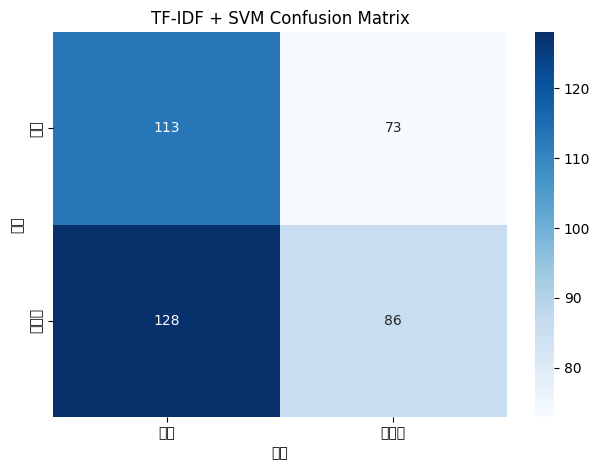

✅ 시각화 완료


In [1]:
print("✅ pandas import 시작")
import pandas as pd
print("✅ pandas import 완료")

print("📥 CSV 파일 로드 중...")
df = pd.read_csv(r"C:\AIhub\train_data.csv", encoding="utf-8")
print("✅ CSV 로딩 완료")

print("📥 sklearn, matplotlib 등 필요한 라이브러리 import 중...")
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
print("✅ 라이브러리 import 완료")

print("🔧 데이터 프레임 컬럼 소문자 및 공백 제거 중...")
df.columns = df.columns.str.strip().str.lower()
print(f"✅ 컬럼명 처리 완료: {df.columns.tolist()}")

print("🔎 텍스트 및 라벨 열 자동 감지 중...")
text_col = next((col for col in df.columns if 'text' in col), None)
label_col = next((col for col in df.columns if 'label' in col or 'class' in col), None)

if not text_col or not label_col:
    raise ValueError(f"❌ 'text' 또는 'label' 관련 열을 찾을 수 없습니다.\n현재 열 목록: {df.columns.tolist()}")
print(f"✅ 텍스트 열: '{text_col}', 라벨 열: '{label_col}' 감지 완료")

# ✅ 빠른 실행을 위한 샘플링 (2000개까지만 사용)
print("📉 데이터 일부 샘플링 중 (최대 2000개)...")
df_sample = df[[text_col, label_col]].dropna().sample(n=2000, random_state=42) if len(df) > 2000 else df
print(f"✅ 샘플링 완료: {len(df_sample)}개")

print("🔀 학습/검증 데이터 분할 중...")
X_train, X_test, y_train, y_test = train_test_split(
    df_sample[text_col], df_sample[label_col], test_size=0.2, random_state=42
)
print(f"✅ 데이터 분할 완료: 학습 {len(X_train)}개, 검증 {len(X_test)}개")

print("🔤 TF-IDF 벡터화 중...")
vectorizer = TfidfVectorizer(max_features=1000)  # 차원 축소
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
print("✅ TF-IDF 벡터화 완료")

print("⚙️ SVM 모델 학습 중 (선형 커널)...")
model = SVC(kernel="linear")  # 빠른 학습을 위한 선형 커널
model.fit(X_train_vec, y_train)
print("✅ SVM 모델 학습 완료")

print("🔍 예측 및 평가 중...")
y_pred = model.predict(X_test_vec)
print("✅ 예측 완료")

print("📊 TF-IDF + SVM 분류 결과")
print(classification_report(y_test, y_pred))

print("📈 혼동 행렬 시각화 중...")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["정상", "어뷰징"], yticklabels=["정상", "어뷰징"])
plt.title("TF-IDF + SVM Confusion Matrix")
plt.xlabel("예측")
plt.ylabel("실제")
plt.tight_layout()
plt.show()
print("✅ 시각화 완료")


In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# 1. 데이터 불러오기
print("📂 1단계: 데이터 불러오는 중...")
df = pd.read_csv(r"C:\AIhub\train_data.csv", encoding='utf-8', engine="python")
df.columns = df.columns.str.strip().str.lower()
df = df[['text', 'label']].dropna()
print(f"✅ 데이터 로드 완료: {len(df)}개 샘플")

# 2. Dataset 포맷 변환
print("📦 2단계: HuggingFace Dataset 포맷으로 변환 중...")
dataset = Dataset.from_pandas(df)
dataset = dataset.train_test_split(test_size=0.2)
print("✅ 변환 및 학습/테스트 분할 완료")

# 3. Tokenizer 준비
print("🔤 3단계: Tokenizer 로딩 및 적용 중...")
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
print("✅ 토큰화 완료")

# 4. 모델 준비
print("🤖 4단계: BERT 모델 로딩 중...")
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
print("✅ 모델 로딩 완료")

# 5. 학습 설정
print("⚙️ 5단계: 학습 파라미터 설정 중...")
training_args = TrainingArguments(
    output_dir="./bert_results",
    evaluation_strategy="epoch",
    save_strategy="no",
    logging_dir="./logs",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    report_to="none"
)
print("✅ 학습 설정 완료")

# 6. Trainer 설정
print("🚀 6단계: Trainer 설정 중...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"]
)
print("✅ Trainer 준비 완료")

# 7. 학습 시작
print("🧠 7단계: 모델 학습 시작...")
trainer.train()
print("✅ 학습 완료")

# 8. 예측 및 평가
print("🔍 8단계: 테스트 데이터 예측 및 성능 평가 중...")
preds = trainer.predict(tokenized_dataset["test"])
y_pred = torch.argmax(torch.tensor(preds.predictions), axis=1).numpy()
y_true = tokenized_dataset["test"]["labels"]

print("📊 BERT 분류 성능 결과:")
print(classification_report(y_true, y_pred))

# 9. 혼동 행렬 시각화
print("📉 9단계: 혼동 행렬 시각화 중...")
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=["Normal", "Abusing"], yticklabels=["Normal", "Abusing"])
plt.title("BERT Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
print("✅ 전체 프로세스 완료!")
